### <kbd> The codes are used to calculate the echo areas and then fit T2 after background calibration

In [ ]:
'''
File: c:\2021_HWU\Python_codes\data_processing\20221010_T2_cal_calibration.ipynb
Created Date: Monday, October 10th 2022, 10:25:11 pm
Author: Wei Jiang
-----
Last Modified: Tuesday, 24th January 2023 10:47:38 pm
Modified By: Wei Jiang
-----
Copyright (c) 2023
-----
HISTORY:
Date      	By	Comments
----------	---	----------------------------------------------------------
'''


In [10]:
import os
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt
import sys
from scipy.integrate import simpson
from scipy.optimize import curve_fit


<kbd> Set the paths of raw data and some parameters

In [11]:
# Set the paths of raw data 
dir = 'C:\\Users\\wj2002\\Dropbox (Heriot-Watt University Team)\\RES_EPS_Quantum_Photonics_Lab\\Experiments\\Current Experiments\\Broadband telecom quantum memories\\2022_Pr_YSO_spectroscopy'
folder = '20220921_Pr_YSO_T2_L'
sub_folders = ['T292104','T292105','T292106','T292107','T292108']

show_plot=0

#path = dir + '\\' + folder + '\\'
#folder_list=[ f.path for f in os.scandir(path) if f.is_dir() ]
num_of_subfolders=np.size(sub_folders)

# Record the experiemental parameters for the measurement
input_power=np.array([1.56, 1.16, 0.84, 0.60, 0.41]) # the laser power before the optical window of the cryostat, unit:mW
pi_pulse_duation=np.array([1.8e-6,2.2e-6,2.8e-6,3.2e-6,4.7e-6]) # pi pulse duaration and pi/2 pulse duration=pi*2/3, unit: s
tau_0=np.array([5e-6, 5e-6, 7e-6, 8e-6, 11e-6]) # the fist seperation between the pi and pi/2 pulses, unit: s
OD=np.array([0.64275,0.488, 0.49869, 0.39245, 0.43528]) # calculated OD based on spectral hole burning 

tau_step=2e-6 # the changing step of the seperation between the pi and pi/2 pulses, unit: s
echo_reading_width=3e-6 # the pulse duration of the read-out pulse, unit: s

ave=20 # average times
steps=20 # changing steps of the seperation between the pi and pi/2 pulses

# Find the dimensions of arrays for initialise the created arrays
path=dir + '\\' + folder + '\\' + sub_folders[0] + '\\'
file_list = os.listdir(path)
list_csv=natsorted([i for i in file_list if i.endswith('.CSV')])
file_size=np.shape(list_csv)
data_file_len=file_size[0]
read_example=pd.read_csv(os.path.join(path,list_csv[0]))
read_example=read_example.to_numpy()
row_of_data, column_of_data=np.shape(read_example)

<kbd> Read raw data and find the averaged background noises for calibration 

In [12]:
tau_measured=np.empty([data_file_len,num_of_subfolders])
echo_area=np.empty([steps*ave,num_of_subfolders])
tau_plot=np.empty([steps,num_of_subfolders])
data_time=np.empty([num_of_subfolders,row_of_data,data_file_len])
data_trigger=np.empty([num_of_subfolders,row_of_data,data_file_len])
data_echo=np.empty([num_of_subfolders,row_of_data,data_file_len])
data_echo_corrected=np.empty([num_of_subfolders,row_of_data,data_file_len])
#data_background=np.empty([row_of_data,data_file_len])
data_background_ave=np.empty([steps*ave,num_of_subfolders])
Trigger_pos=np.empty([num_of_subfolders,2,data_file_len])
pulses_pos=np.empty([num_of_subfolders,4,data_file_len])

# Define the fitting fuction
def TPE(x,y0,T2):
    return y0*np.exp(-4*x/T2)

# Set up the time range for data processing
time_offset_left=10
time_offset_right=180

# Values for finding the trigger, pi pulse, and pi/2 pulses
trigger_val = 1.5
pulses_val = 0.007

for index_0, file_0 in enumerate(sub_folders):
    # This loop is used to get the path for each measurement when changing the input power
    path=dir + '\\' + folder + '\\' + file_0 + '\\'
    for index_1, file_1 in enumerate(list_csv):
        # This loop is used to read and average the traces saved for one input power
        data=pd.read_csv(os.path.join(path,file_1))
        data=data.to_numpy()
        # Read raw data - two-pulse echo
        data_time[index_0,:,index_1]=data[:,0]
        data_time_1=data[:,0]
        # Read raw data - the trigger signal
        data_trigger[index_0,:,index_1]=data[:,1]
        data_trigger_1=data[:,1]
    
        # Find the trigger signal of the two-pulse echos
        mask1 = (data_trigger_1[:-1] < trigger_val) & (data_trigger_1[1:] > trigger_val)
        mask2 = (data_trigger_1[:-1] > trigger_val) & (data_trigger_1[1:] < trigger_val)
        Trigger_pos[index_0,:,index_1]=np.flatnonzero(mask1 | mask2)+1
        
        # Calibrate the data using the background
        data_echo[index_0,:,index_1]=data[:,2]
        data_echo_1=data[:,2]
        data_background=data_echo_1[(int(Trigger_pos[index_0,1,index_1])+time_offset_right):]
        data_background_ave[index_1,index_0]=np.sum(data_background)/(len(data_background))
        
        data_echo_corrected[index_0,:,index_1]=data_echo[index_0,:,index_1]-data_background_ave[index_1,index_0]
        data_echo_corrected_1=data_echo_corrected[index_0,:,index_1]

        # Find the rising edges of the pi/2 and pi pulses
        mask3 = (data_echo_corrected_1[:-1] < pulses_val) & (data_echo_corrected_1[1:] > pulses_val)
        mask4 = (data_echo_corrected_1[:-1] > pulses_val) & (data_echo_corrected_1[1:] < pulses_val)
        pulses_pos=np.flatnonzero(mask3 | mask4)+1

        # Try to 
        tau_measured[index_1,index_0] = 1e6*np.abs(data_time_1[pulses_pos[0]]-data_time_1[pulses_pos[2]])+pi_pulse_duation[index_0]/4
        #print(tau_measured[index_1,index_0])

        time_int=data_time[index_0,int(Trigger_pos[index_0,0,0])-time_offset_left:int(Trigger_pos[index_0,1,0])+time_offset_right,index_1]
        echo_int=data_echo_corrected[index_0,int(Trigger_pos[index_0,0,0])-time_offset_left:int(Trigger_pos[index_0,1,0])+time_offset_right,index_1]
        echo_area[index_1,index_0]=simpson(echo_int, time_int)
    
        if show_plot==1:
            fig1, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ax1.plot(data_time_1[int(pulses_pos[0])-time_offset_left:int(Trigger_pos[1,0])+time_offset_right,index_1], data_trigger_1[int(pulses_pos[0])-time_offset_left:int(Trigger_pos[1,0])+time_offset_right,index_1], 'g-')
            ax2.plot(data_time_1[int(pulses_pos[0])-time_offset_left:int(Trigger_pos[1,0])+time_offset_right,index_1], data_echo_1[int(pulses_pos[0])-time_offset_left:int(Trigger_pos[1,0])+time_offset_right,index_1], 'b-')
            plt.show()

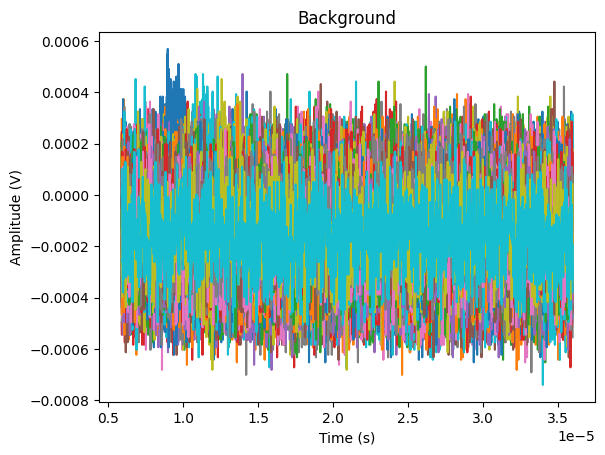

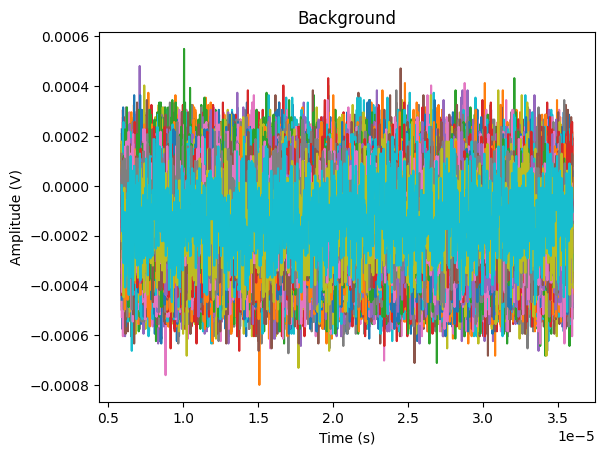

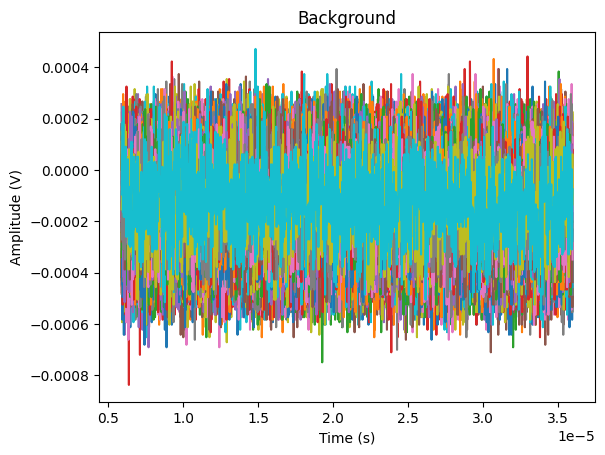

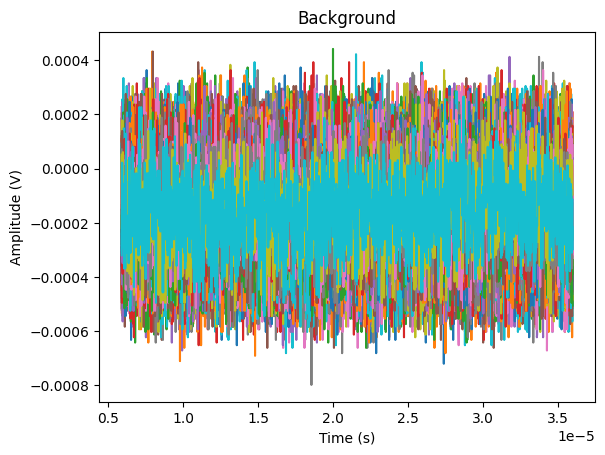

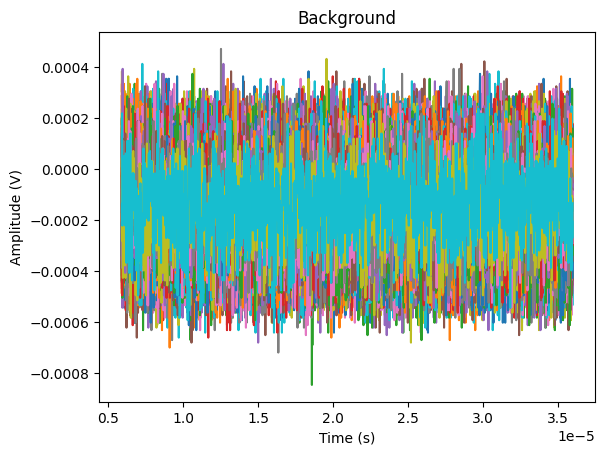

In [5]:
for index_0 in range(num_of_subfolders):
    plt.figure()
    for index_2 in range(len(data_background_ave)):
        plt.plot(data_time[index_0, (int(Trigger_pos[index_0,1,index_2])+time_offset_right):,index_2],data_echo[index_0, (int(Trigger_pos[index_0,1,index_2])+time_offset_right):,index_2])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (V)')
        plt.title('Background')


In [13]:
data_echo_area=np.empty([steps,num_of_subfolders])
data_echo_area_ave=np.empty([ave,num_of_subfolders])
data_echo_SD_0=np.empty([ave,num_of_subfolders])
data_echo_SD=np.empty([steps,num_of_subfolders])
data_echo_error=np.empty([steps,num_of_subfolders])

for index_0 in range(num_of_subfolders):
    for ii in range(steps):
        jj=0
        while jj<ave:
            data_echo_area[jj,index_0]=echo_area[ii+(jj)*steps,index_0]
            jj=jj+1  
        data_echo_area_ave[ii,index_0]=np.sum(data_echo_area[:,index_0])/ave
    
        kk=0
        while kk<ave:
            data_echo_SD_0[kk,index_0]=np.square(echo_area[ii+(kk)*steps,index_0]-data_echo_area_ave[ii,index_0])
            kk=kk+1
    
        data_echo_SD[ii,index_0]=np.sqrt(np.sum(data_echo_SD_0[:,index_0])/(ave-1))
        data_echo_error[ii,index_0]=data_echo_SD[ii,index_0]/np.sqrt(ave)
        
        data_time_plot=data_time[index_0,int(Trigger_pos[index_0,0,0])-time_offset_left:int(Trigger_pos[index_0,1,0])+time_offset_right,ii]
        data_trigger_plot=data_trigger[index_0,int(Trigger_pos[index_0,0,0])-time_offset_left:int(Trigger_pos[index_0,1,0])+time_offset_right,ii]
        tau_plot[ii,index_0]=tau_measured[ii,index_0]*1e-6

In [14]:
T2_fit=np.empty(num_of_subfolders)
T2_err_true=np.empty(num_of_subfolders)
T2_fit_amp=np.empty(num_of_subfolders)
for index_0 in range(num_of_subfolders):
    T2_fit_0,T2_err=curve_fit(TPE, tau_plot[:,index_0], data_echo_area_ave[:,index_0], p0=[1e-9,50e-6],sigma=data_echo_error[:,index_0])
    T2_fit[index_0]=T2_fit_0[1]
    T2_fit_amp[index_0]=T2_fit_0[0]
    T2_err_true_0=np.sqrt(np.diag(T2_err))
    T2_err_true[index_0]=T2_err_true_0[1]
    print('fitted T2 =', T2_fit[index_0]*1e6, 'us')
    print('fitted T2 error =', T2_err_true[index_0]*1e6, 'us')

fitted T2 = 45.73135599742149 us
fitted T2 error = 2.095287949402651 us
fitted T2 = 44.581211438192746 us
fitted T2 error = 2.797741857201378 us
fitted T2 = 44.62541251365061 us
fitted T2 error = 3.23549824553947 us
fitted T2 = 51.410366818119705 us
fitted T2 error = 4.032441333952373 us
fitted T2 = 58.809330215151 us
fitted T2 error = 3.6767987392210135 us


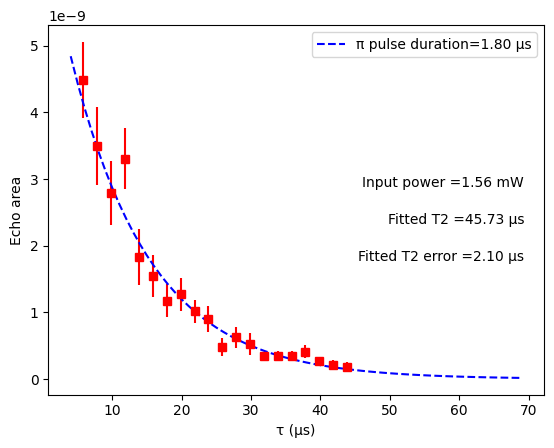

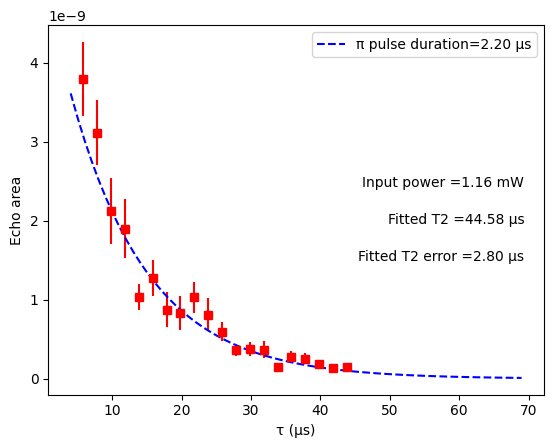

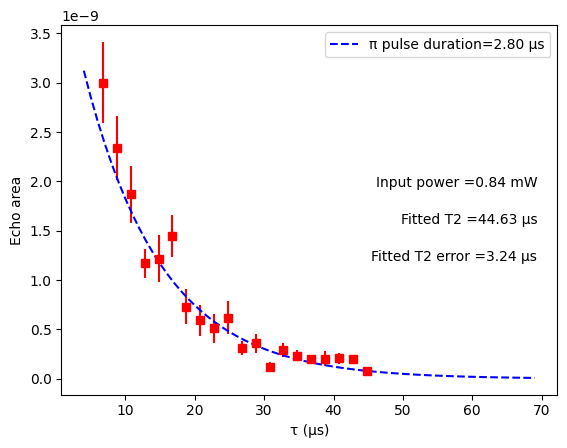

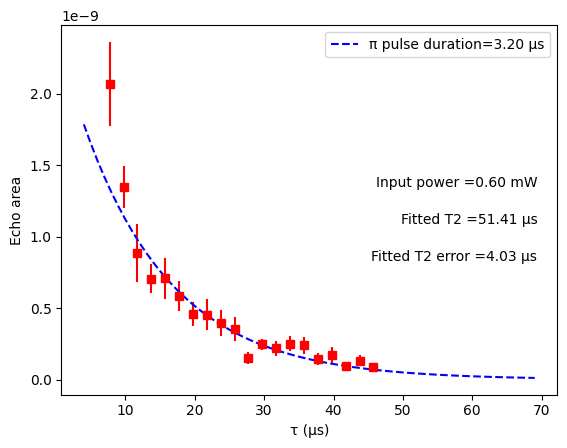

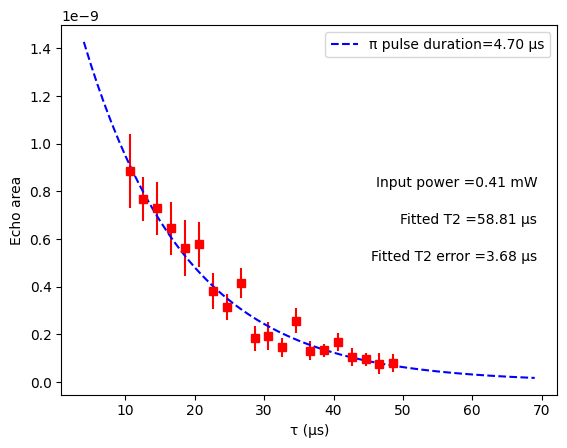

In [15]:
for index_0 in range(num_of_subfolders):
    fig, ax=plt.subplots()
    ax.errorbar(tau_plot[:,index_0]*1e6, data_echo_area_ave[:,index_0], yerr=data_echo_error[:,index_0],fmt="sr")
    xx=np.arange(4e-6,70e-6,10e-7)
    T2_fit_curve=T2_fit_amp[index_0]*np.exp(-4*xx/T2_fit[index_0])
    ax.plot(xx*1e6,T2_fit_curve,'b--',label='\u03C0 pulse duration='+"{:.2f}".format(pi_pulse_duation[index_0]*1e6)+' \u03BCs')
    ax.legend(handlelength=2)
    ax.set_xlabel('\u03C4 (\u03BCs)')
    ax.set_ylabel('Echo area')
    ax.annotate('Input power ='+"{:.2f}".format(input_power[index_0])+' mW',
            xy=(1, 0.5), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
    ax.annotate('Fitted T2 ='+"{:.2f}".format(T2_fit[index_0]*1e6)+' \u03BCs',
            xy=(1, 0.4), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
    ax.annotate('Fitted T2 error ='+"{:.2f}".format(T2_err_true[index_0]*1e6)+' \u03BCs',
            xy=(1, 0.3), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
    plt.show()

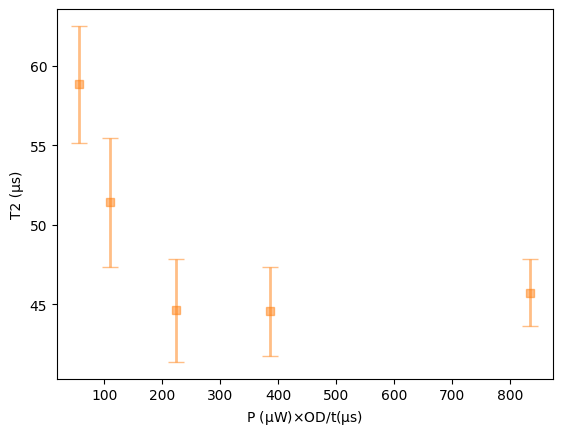

In [16]:
exc_int=input_power*1e-3*OD/(2*pi_pulse_duation/3)
fig, ax=plt.subplots()

ax.errorbar(exc_int, T2_fit*1e6, yerr=T2_err_true*1e6,c='tab:orange',fmt='s',alpha=0.5,linewidth=2, capsize=6)
ax.set_xlabel('P (\u03BCW)' r'$\times$' 'OD/t(\u03BCs)')
ax.set_ylabel('T2 (\u03BCs)')
plt.show()